# Data & Results

get Aarronson replication data to work from https://www.aeaweb.org/articles?id=10.1257/pol.20190414

## Import Maps & RL Data

In [1]:
import os
import geopandas as gpd
import pandas as pd

# Fix PROJ path if needed (for coordinate transforms)
os.environ["PROJ_LIB"] = "/home/idies/mambaforge/envs/econark/share/proj"

# === 1. Load HOLC data ===
holc = gpd.read_file("mappinginequality.gpkg")

# === 2. Filter for Chicago ===
holc_chi = holc[holc["city"].str.contains("Chicago", case=False, na=False)].copy()
print(f"HOLC polygons loaded for Chicago: {len(holc_chi)}")

# Keep relevant columns
holc_chi = holc_chi[["area_id", "grade", "geometry"]]

# Display a preview table
display(holc_chi.head())

# === 3. Ensure coordinate system is projected in meters ===
# This step is required for buffer distances
holc_chi = holc_chi.to_crs(epsg=26916)  # NAD83 / UTM zone 16N (covers Chicago region)

# === 4. Create 0.25-mile (≈402 meters) buffers around each HOLC boundary ===
buffer_distance = 402  # meters
holc_buffers = holc_chi.copy()
holc_buffers["geometry"] = holc_buffers.buffer(buffer_distance)

print(f"Created buffer zones of {buffer_distance} meters around each HOLC area.")

# Preview buffers (optional)
display(holc_buffers.head())

# === 5. (Optional) Save buffers for reference ===
holc_buffers.to_file("holc_chicago_buffers.geojson", driver="GeoJSON")


HOLC polygons loaded for Chicago: 703


,area_id,grade,geometry
2014,11474,C,"POLYGON ((-87.86999 41.8197, -87.87006 41.8233..."
2015,1065,A,"MULTIPOLYGON (((-87.83054 42.25361, -87.82979 ..."
2016,1091,A,"MULTIPOLYGON (((-87.76217 42.12934, -87.76233 ..."
2017,1097,A,"MULTIPOLYGON (((-87.75082 42.13867, -87.75053 ..."
2018,1098,A,"MULTIPOLYGON (((-87.74436 42.12695, -87.74135 ..."


Created buffer zones of 402 meters around each HOLC area.


,area_id,grade,geometry
2014,11474,C,"POLYGON ((426501.158 4631102.289, 426501.124 4..."
2015,1065,A,"POLYGON ((430989.125 4678536.198, 430972.686 4..."
2016,1091,A,"POLYGON ((436050.786 4664575.527, 436017.29 46..."
2017,1097,A,"POLYGON ((437691.157 4665139.636, 437664.449 4..."
2018,1098,A,"POLYGON ((437876.08 4664646.724, 437715.346 46..."


### Table 1
- There are 703 mapped areas (neighborhood polygons) in Chicago that were graded by the Home Owners’ Loan Corporation (HOLC) in the 1930s.
- Each of these polygons corresponds to a distinct neighborhood “area” on the redlining map.

### Table 2
- created 0.25-mile buffer polygons (≈402 meters) around each HOLC area.
- The geometry numbers are now in meters, not degrees**,** because we switched to a projected coordinate system — this allows accurate measurement of distances like “0.25 miles.”

## Import School Data

In [2]:
import pandas as pd

# === 1. Load both files ===
locations = pd.read_csv("school-locations.csv", dtype=str)
school_info = pd.read_csv("school-level.csv", dtype=str)

# === 2. Merge on NCESSCH (the unique school code) ===
merged = locations.merge(school_info, on="NCESSCH", how="inner")

# === 3. Filter for Chicago high schools ===
# Check column names that describe school type (they vary by dataset)
# Common ones include "LEVEL", "SCH_LEVEL", or "SCHOOL_TYPE"
# You can inspect available columns with:
# print(merged.columns)

# Example: assuming the column indicating school level is "LEVEL"
# and that high schools are labeled "High" or contain the word "High"
merged_chi = merged[
    (merged["CITY"].str.contains("Chicago", case=False, na=False)) &
    (merged["SCH_TYPE"].str.contains("1", case=False, na=False))
].copy()

# === 4. Keep relevant columns ===
cols_to_keep = ["NCESSCH", "NAME", "LAT", "LON", "CITY", "STATE"]
merged_chi = merged_chi[cols_to_keep]

# === 5. Convert coordinates to numeric (for mapping / GeoDataFrame use later) ===
merged_chi["LAT"] = merged_chi["LAT"].astype(float)
merged_chi["LON"] = merged_chi["LON"].astype(float)


# === 6. Display the resulting table ===
print("\n=== Chicago High Schools with Coordinates ===")
print(merged_chi.head(20).to_string(index=False))

# === 7. (Optional) Save to CSV for use in GIS or later analysis ===
merged_chi.to_csv("chicago_high_schools_with_coords.csv", index=False)


=== Chicago High Schools with Coordinates ===
     NCESSCH                              NAME       LAT        LON            CITY STATE
170011004813         Neal Math Science Academy 42.324000 -87.855350   North Chicago    IL
170011004814           A J Katzenmaier Academy 42.326049 -87.862726   North Chicago    IL
170011004815           Evelyn Alexander School 42.337313 -87.840019   North Chicago    IL
170011005370  North Chicago Community High Sch 42.328032 -87.853182   North Chicago    IL
170011006357  Green Bay Early Childhood Center 42.320900 -87.868603   North Chicago    IL
170011006401           LEARN 10 Charter School 42.315417 -87.853826   North Chicago    IL
170141006254  Horizon Science Acad-McKinley Pk 41.822594 -87.682103         Chicago    IL
170141206309      Horizon Science Acad-Belmont 41.925459 -87.770026         Chicago    IL
170142406394 Betty Shabazz Internl Charter Sch 41.752403 -87.599982         Chicago    IL
170142406396         Barbara A Sizemore Campus 41.775

## Chicago Schools in HOLC Boundary

In [3]:
import os
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# === 1. Load HOLC polygons and buffers ===
holc = gpd.read_file("mappinginequality.gpkg")
holc = holc[holc["city"].str.contains("Chicago", case=False, na=False)].copy()
holc = holc.to_crs(epsg=26916)  # UTM zone 16N

holc_buffers = gpd.read_file("holc_chicago_buffers.geojson").to_crs(epsg=26916)

# === 2. Load school location data ===
school_locations = pd.read_csv("school-locations.csv", dtype=str)
school_locations["LAT"] = school_locations["LAT"].astype(float)
school_locations["LON"] = school_locations["LON"].astype(float)

# Convert to GeoDataFrame
schools_gdf = gpd.GeoDataFrame(
    school_locations,
    geometry=gpd.points_from_xy(school_locations["LON"], school_locations["LAT"]),
    crs="EPSG:4326"
).to_crs(epsg=26916)

# === 3. Filter for Chicago high schools only ===
schools_chi = schools_gdf[schools_gdf["CITY"].str.contains("Chicago", case=False, na=False)].copy()
mask_exclude = schools_chi["NAME"].str.contains("elem|elementary|middle", case=False, na=False)
schools_chi = schools_chi[~mask_exclude].copy()
print(f"High schools in Chicago: {len(schools_chi)}")

# === 4. Assign actual HOLC district the school is in ===
schools_in_holc = gpd.sjoin(schools_chi, holc[["area_id", "grade", "geometry"]], how="left", predicate="within")

# Drop duplicates in case a school overlaps multiple polygons (should be rare)
schools_in_holc = schools_in_holc.drop_duplicates(subset="NCESSCH")

# === 5. Count number of HOLC buffer zones each school overlaps (optional) ===
overlap_counts = gpd.sjoin(schools_chi, holc_buffers, how="inner", predicate="intersects")
zone_count = overlap_counts.groupby("NCESSCH").size().reset_index(name="zone_count")

# === 6. Merge actual HOLC info with buffer overlap count ===
schools_combined = schools_in_holc.merge(zone_count, on="NCESSCH", how="left")
schools_combined["zone_count"] = schools_combined["zone_count"].fillna(0).astype(int)

# === 7. Drop schools with no HOLC grade ===
schools_combined = schools_combined[schools_combined["grade"].notna()].copy()
print(f"High schools with HOLC grade info: {len(schools_combined)}")

# === 8. Keep relevant columns ===
schools_combined = schools_combined[[
    "NCESSCH", "NAME", "LAT", "LON", "grade"
]]

# === 9. Preview results ===
print("\n=== Preview of combined results ===")
print(schools_combined.head(10).to_string(index=False))

# === 10. Save to CSV if needed ===
#output_file = "Chicago_HS_RL.csv"
#schools_combined.to_csv(output_file, index=False)
#print(f"✅ Cleaned table saved to: {os.path.abspath(output_file)}")


High schools in Chicago: 262
High schools with HOLC grade info: 159

=== Preview of combined results ===
     NCESSCH                              NAME       LAT        LON grade
170000603793                       IYC Chicago 41.884126 -87.687997     D
170009805220      IL Center for Rehab & Educ-R 41.867200 -87.675500     D
170141206309      Horizon Science Acad-Belmont 41.925459 -87.770026     C
170142406394 Betty Shabazz Internl Charter Sch 41.752403 -87.599982     C
170142406396         Barbara A Sizemore Campus 41.775011 -87.634407     D
170142606424        ACE Amandla Charter School 41.769223 -87.690965     C
170143106434   Bronzeville Academy Charter Sch 41.805200 -87.606919     D
170143606756  Urban Prep Chrtr Sch for Yng Men 41.876384 -87.625564     D
170993000588  Dunbar Vocational Career Acad HS 41.839600 -87.618700     D
170993000612        Mosaic School of Fine Arts 42.003600 -87.697900     B


## Import Calculus Data

In [4]:
import os
import pandas as pd

# === 1. Load your existing redline-filtered Chicago high schools ===
holc_schools_file = "Chicago_HS_RL.csv"
holc_schools = pd.read_csv(holc_schools_file, dtype=str)

print(f"HOLC-filtered schools loaded: {len(holc_schools)}")

# === 2. Load Calculus CRDC data ===
calc_path = os.path.join("2020-21-crdc-data", "CRDC", "School", "Calculus.csv")
calc = pd.read_csv(calc_path, dtype=str)
print(f"Calculus dataset loaded: {len(calc)} rows")

# Convert numeric column safely
calc["SCH_MATHCLASSES_CALC"] = pd.to_numeric(calc["SCH_MATHCLASSES_CALC"], errors="coerce")

# === 3. Filter for valid (non-negative) calculus values ===
calc = calc[calc["SCH_MATHCLASSES_CALC"] >= 0].copy()
print(f"Schools with valid calculus data: {len(calc)}")

# === 4. Merge by NCES ID (COMBOKEY ↔ NCESSCH) ===
merged = holc_schools.merge(
    calc[["COMBOKEY", "SCH_NAME", "SCH_MATHCLASSES_CALC"]],
    left_on="NCESSCH", right_on="COMBOKEY", how="inner"
)

print(f"Merged overlapping schools: {len(merged)}")

# === 5. Create indicator columns ===
merged["SCH_MATHCLASSES_CALC"] = merged["SCH_MATHCLASSES_CALC"].astype(int)
merged["Has_Calc"] = merged["SCH_MATHCLASSES_CALC"].apply(lambda x: "Yes" if x > 0 else "No")
merged["Num_Calc_Classes"] = merged["SCH_MATHCLASSES_CALC"]

# === 6. Keep relevant columns ===
calc_summary = merged[[
    "NCESSCH", "NAME", "LAT", "LON", "grade",  
    "Has_Calc", "Num_Calc_Classes"
]]

# === 7. Save to CSV ===
#output_file = "Calc_HS_Chicago.csv"
#calc_summary.to_csv(output_file, index=False)
#print(f"✅ Combined table saved to: {os.path.abspath(output_file)}")

# === 8. Preview first few rows ===
print("\n=== Preview of Calculus-overlapping schools ===")
print(calc_summary.head(10).to_string(index=False))


HOLC-filtered schools loaded: 159
Calculus dataset loaded: 97575 rows
Schools with valid calculus data: 26331
Merged overlapping schools: 111

=== Preview of Calculus-overlapping schools ===
     NCESSCH                             NAME       LAT        LON grade Has_Calc  Num_Calc_Classes
170000603793                      IYC Chicago 41.884126 -87.687997     D       No                 0
170142606424       ACE Amandla Charter School 41.769223 -87.690965     C       No                 0
170143606756 Urban Prep Chrtr Sch for Yng Men 41.876384 -87.625564     D       No                 0
170993000588 Dunbar Vocational Career Acad HS   41.8396   -87.6187     D       No                 0
170993000714         Young Magnet High School   41.8783   -87.6637     D      Yes                 8
170993000718       Richards Career Academy HS   41.8028   -87.6621     D       No                 0
170993000722      Juarez Community Academy HS 41.852914  -87.66456     D       No                 0
170993000

## Import CS Data

In [5]:
import os
import pandas as pd

holc_schools = pd.read_csv("Chicago_HS_RL.csv", dtype=str)

csci_path = os.path.join("2020-21-crdc-data", "CRDC", "School", "Computer Science.csv")
csci = pd.read_csv(csci_path, dtype=str)

csci["SCH_COMPCLASSES_CSCI"] = pd.to_numeric(csci["SCH_COMPCLASSES_CSCI"], errors="coerce")
csci = csci[csci["SCH_COMPCLASSES_CSCI"] >= 0].copy()

csci_merged = holc_schools.merge(
    csci[["COMBOKEY", "SCH_NAME", "SCH_COMPCLASSES_CSCI"]],
    left_on="NCESSCH", right_on="COMBOKEY", how="inner"
)

csci_merged["SCH_COMPCLASSES_CSCI"] = csci_merged["SCH_COMPCLASSES_CSCI"].astype(int)
csci_merged["Has_CS"] = csci_merged["SCH_COMPCLASSES_CSCI"].apply(lambda x: "Yes" if x > 0 else "No")
csci_merged["Num_CS_Classes"] = csci_merged["SCH_COMPCLASSES_CSCI"]

csci_final = csci_merged[[
    "NCESSCH", "NAME", "LAT", "LON", "grade", "Has_CS", "Num_CS_Classes"
]]

#output_file = "CS_HS_Chicago.csv"
#csci_final.to_csv(output_file, index=False)
#print(f"✅ Computer Science CSV saved to: {os.path.abspath(output_file)}")


## Import Physics Data

In [6]:
import os
import pandas as pd

holc_schools = pd.read_csv("Chicago_HS_RL.csv", dtype=str)

phys_path = os.path.join("2020-21-crdc-data", "CRDC", "School", "Physics.csv")
phys = pd.read_csv(phys_path, dtype=str)

phys["SCH_SCICLASSES_PHYS"] = pd.to_numeric(phys["SCH_SCICLASSES_PHYS"], errors="coerce")
phys = phys[phys["SCH_SCICLASSES_PHYS"] >= 0].copy()

phys_merged = holc_schools.merge(
    phys[["COMBOKEY", "SCH_NAME", "SCH_SCICLASSES_PHYS"]],
    left_on="NCESSCH", right_on="COMBOKEY", how="inner"
)

phys_merged["SCH_SCICLASSES_PHYS"] = phys_merged["SCH_SCICLASSES_PHYS"].astype(int)
phys_merged["Has_Physics"] = phys_merged["SCH_SCICLASSES_PHYS"].apply(lambda x: "Yes" if x > 0 else "No")
phys_merged["Num_Physics_Classes"] = phys_merged["SCH_SCICLASSES_PHYS"]

phys_final = phys_merged[[
    "NCESSCH", "NAME", "LAT", "LON", "grade", "Has_Physics", "Num_Physics_Classes"
]]

#output_file = "Phys_HS_Chicago.csv"
#phys_final.to_csv(output_file, index=False)
#print(f"✅ Physics CSV saved to: {os.path.abspath(output_file)}")


## Merge Datasets

In [7]:
import pandas as pd

calc = pd.read_csv("Calc_HS_Chicago.csv", dtype=str)
csci = pd.read_csv("CS_HS_Chicago.csv", dtype=str)
phys = pd.read_csv("Phys_HS_Chicago.csv", dtype=str)

# Merge sequentially on NCESSCH
combined = calc.merge(csci[["NCESSCH", "Has_CS", "Num_CS_Classes"]], on="NCESSCH", how="outer")
combined = combined.merge(phys[["NCESSCH", "Has_Physics", "Num_Physics_Classes"]], on="NCESSCH", how="outer")

# Replace NaNs with "No" or 0
combined["Has_Calc"] = combined["Has_Calc"].fillna("No")
combined["Has_CS"] = combined["Has_CS"].fillna("No")
combined["Has_Physics"] = combined["Has_Physics"].fillna("No")

for col in ["Num_Calc_Classes", "Num_CS_Classes", "Num_Physics_Classes"]:
    combined[col] = pd.to_numeric(combined[col], errors="coerce").fillna(0).astype(int)

# Save merged CSV
#output_file = "All_Classes_HS_Chicago.csv"
#combined.to_csv(output_file, index=False)
#print(f"✅ All class data merged and saved to: {output_file}")

print("\n=== Preview of combined table ===")
print(combined.head(10).to_string(index=False))



=== Preview of combined table ===
     NCESSCH                             NAME       LAT        LON grade Has_Calc  Num_Calc_Classes Has_CS  Num_CS_Classes Has_Physics  Num_Physics_Classes
170000603793                      IYC Chicago 41.884126 -87.687997     D       No                 0     No               0          No                    0
170142606424       ACE Amandla Charter School 41.769223 -87.690965     C       No                 0     No               0         Yes                    2
170143606756 Urban Prep Chrtr Sch for Yng Men 41.876384 -87.625564     D       No                 0     No               0         Yes                    2
170993000588 Dunbar Vocational Career Acad HS   41.8396   -87.6187     D       No                 0     No               0         Yes                    5
170993000714         Young Magnet High School   41.8783   -87.6637     D      Yes                 8    Yes              23         Yes                   34
170993000718       Richards C

## Data Visualization

### % Bar Chart

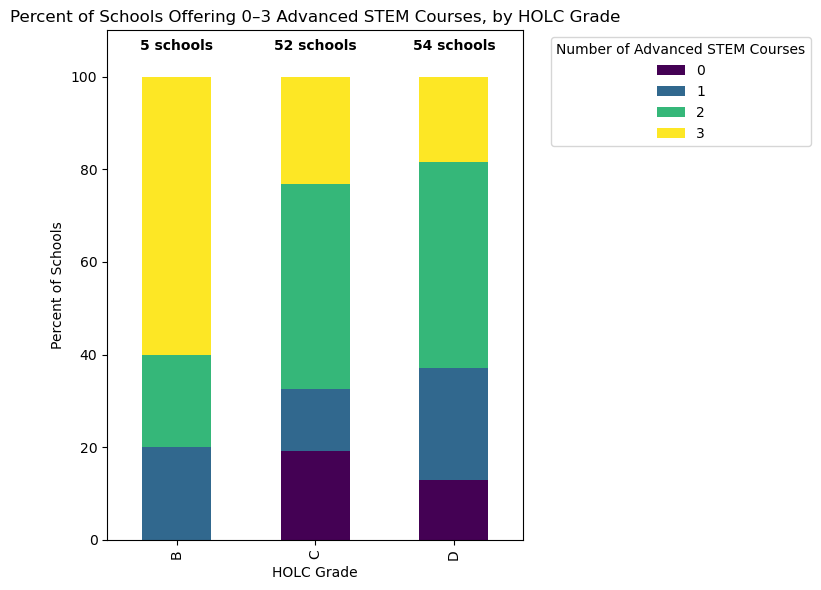

=== Percent and Count of Schools Offering 0–3 Advanced STEM Courses, by HOLC Grade ===
Course_Profile  Total_Schools   0  0_pct   1  1_pct   2  2_pct   3  3_pct
grade                                                                    
B                           5   0    0.0   1   20.0   1   20.0   3   60.0
C                          52  10   19.2   7   13.5  23   44.2  12   23.1
D                          54   7   13.0  13   24.1  24   44.4  10   18.5


In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# --- Create the Course_Profile variable ---
df["Course_Profile"] = (
    df["Has_Calc"].map({"Yes": 1, "No": 0}) +
    df["Has_CS"].map({"Yes": 1, "No": 0}) +
    df["Has_Physics"].map({"Yes": 1, "No": 0})
)

# --- Count schools by HOLC grade and course profile ---
profile_counts = df.groupby(["grade", "Course_Profile"]).size().unstack(fill_value=0)

# --- Convert to percentages within each HOLC grade ---
profile_percents = profile_counts.div(profile_counts.sum(axis=1), axis=0) * 100

# --- Plot as stacked bar chart ---
ax = profile_percents.plot(
    kind="bar",
    stacked=True,
    colormap="viridis",
    figsize=(8,6)
)

# --- Add total school counts above each bar ---
totals = profile_counts.sum(axis=1)
for i, total in enumerate(totals):
    ax.text(
        i, 105,                # position above the bar (y=105 so it’s just above 100%)
        f"{int(total)} schools",
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold"
    )

# --- Formatting ---
ax.set_ylabel("Percent of Schools")
ax.set_xlabel("HOLC Grade")
ax.set_title("Percent of Schools Offering 0–3 Advanced STEM Courses, by HOLC Grade")
ax.legend(title="Number of Advanced STEM Courses", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.ylim(0, 110)  # make space for labels above bars
plt.tight_layout()
plt.show()


# --- Accompanying Table ---

# --- Create the same grouped counts as before ---
profile_counts = df.groupby(["grade", "Course_Profile"]).size().unstack(fill_value=0)

# --- Compute totals and percentages ---
profile_percents = profile_counts.div(profile_counts.sum(axis=1), axis=0) * 100
profile_percents = profile_percents.round(1)  # round to one decimal place

# --- Combine counts and percents into one summary table ---
summary_table = profile_counts.copy()
for col in profile_counts.columns:
    summary_table[f"{col}_pct"] = profile_percents[col]

# --- Add total number of schools per HOLC grade ---
summary_table["Total_Schools"] = profile_counts.sum(axis=1)

# --- Reorder columns for clarity ---
ordered_cols = ["Total_Schools"]
for col in sorted(profile_counts.columns):
    ordered_cols.extend([col, f"{col}_pct"])
summary_table = summary_table[ordered_cols]

# --- Display nicely ---
print("=== Percent and Count of Schools Offering 0–3 Advanced STEM Courses, by HOLC Grade ===")
print(summary_table.to_string())

# --- (Optional) Save to CSV ---
# summary_table.to_csv("holc_stem_course_summary_table.csv")

### Notes on % Bar Chart
- there are a few charter and magnet schools in D districts. this could be skewing the results to some extent
- while a small sample, we do see that schools in B districts are more likely to offer advanced STEM courses

## HOLC Map of Schools Offering Calc
just change to different csv to plot other courses

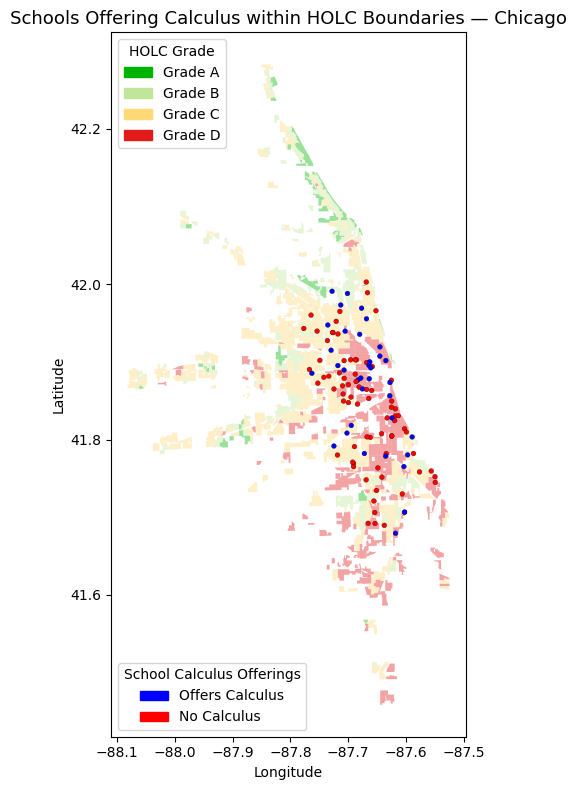

In [11]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# === 1. Load HOLC boundaries ===
holc = gpd.read_file("mappinginequality.gpkg")
holc = holc[holc["city"].str.contains("Chicago", case=False, na=False)].copy()
holc = holc.to_crs(epsg=4326)

# Clean up grade labels
holc["grade"] = holc["grade"].str.strip().str.upper()
holc = holc[holc["grade"].isin(["A", "B", "C", "D"])]

# Define custom colors for grades (to match HOLC standard)
holc_colors = {
    "A": "#00b300",  # green
    "B": "#c2e699",  # light green
    "C": "#fed976",  # yellow
    "D": "#e31a1c"   # red
}

# === 2. Load your school CSV ===
schools_df = pd.read_csv("Calc_HS_Chicago.csv")

# === 3. Convert schools to GeoDataFrame ===
geometry = [Point(xy) for xy in zip(schools_df["LON"].astype(float), schools_df["LAT"].astype(float))]
schools = gpd.GeoDataFrame(schools_df, geometry=geometry, crs="EPSG:4326")

# === 4. Plot base map ===
fig, ax = plt.subplots(figsize=(10, 8))

# Plot each HOLC grade manually (for proper legend control)
for grade, color in holc_colors.items():
    holc[holc["grade"] == grade].plot(ax=ax, color=color, alpha=0.4, label=f"HOLC {grade}")

# === 5. Plot schools ===
schools.plot(
    ax=ax,
    color=schools["Has_Calc"].map({"Yes": "blue", "No": "red"}),
    markersize=12,
    edgecolor="black",
    linewidth=0.2
)

# === 6. Create legends ===
# HOLC zone legend
holc_handles = [mpatches.Patch(color=color, label=f"Grade {grade}") for grade, color in holc_colors.items()]

# School legend
school_handles = [
    mpatches.Patch(color='blue', label='Offers Calculus'),
    mpatches.Patch(color='red', label='No Calculus')
]

# Add both legends (place one manually below the other)
legend1 = ax.legend(handles=holc_handles, title="HOLC Grade", loc='upper left')
ax.add_artist(legend1)
legend2 = ax.legend(handles=school_handles, title="School Calculus Offerings", loc='lower left')

# === 7. Formatting ===
plt.title("Schools Offering Calculus within HOLC Boundaries — Chicago", fontsize=13)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()


## HOLC Map of Scools Offering All Classes

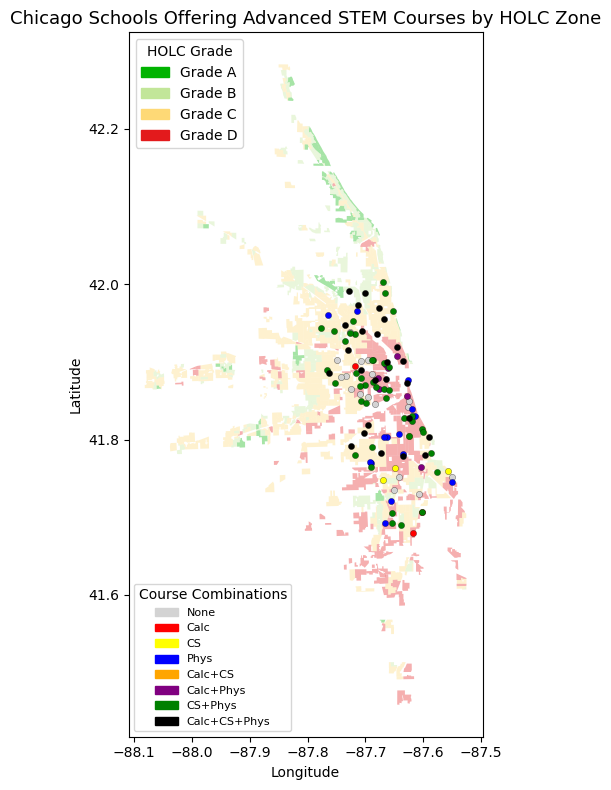

In [21]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# === Load HOLC boundaries ===
holc = gpd.read_file("mappinginequality.gpkg")
holc = holc[holc["city"].str.contains("Chicago", case=False, na=False)].copy()
holc = holc.to_crs(epsg=4326)
holc["grade"] = holc["grade"].str.strip().str.upper()
holc = holc[holc["grade"].isin(["A", "B", "C", "D"])]

holc_colors = {
    "A": "#00b300",
    "B": "#c2e699",
    "C": "#fed976",
    "D": "#e31a1c"
}

# === Load your merged dataset (with Has_Calc, Has_CSCI, Has_PHYS) ===
schools_df = pd.read_csv("All_Classes_HS_Chicago.csv")

# === Create a course combination label ===
def course_combo(row):
    courses = []
    if row["Has_Calc"] == "Yes":
        courses.append("Calc")
    if row["Has_CS"] == "Yes":
        courses.append("CS")
    if row["Has_Physics"] == "Yes":
        courses.append("Phys")
    if not courses:
        return "None"
    return "+".join(courses)

schools_df["Course_Combo"] = schools_df.apply(course_combo, axis=1)

# === Assign colors for combinations ===
combo_colors = {
    "None": "lightgray",
    "Calc": "red",
    "CS": "yellow",
    "Phys": "blue",
    "Calc+CS": "orange",
    "Calc+Phys": "purple",
    "CS+Phys": "green",
    "Calc+CS+Phys": "black"
}

# === Convert schools to GeoDataFrame ===
geometry = [Point(xy) for xy in zip(schools_df["LON"].astype(float), schools_df["LAT"].astype(float))]
schools = gpd.GeoDataFrame(schools_df, geometry=geometry, crs="EPSG:4326")

# === Plot map ===
fig, ax = plt.subplots(figsize=(10, 8))

# Plot HOLC zones manually
for grade, color in holc_colors.items():
    holc[holc["grade"] == grade].plot(ax=ax, color=color, alpha=0.35, label=f"HOLC {grade}")

# Plot schools by combo (fixed: removed linewidth)
for combo, color in combo_colors.items():
    subset = schools[schools["Course_Combo"] == combo]
    if not subset.empty:  # only plot if data exists
        subset.plot(
            ax=ax,
            color=color,
            markersize=20,
            edgecolor="black",
            linewidths=0.2,  # note: plural form works for points
            label=combo,
        )

# === Create legends ===
holc_legend = [mpatches.Patch(color=color, label=f"Grade {grade}") for grade, color in holc_colors.items()]
combo_legend = [mpatches.Patch(color=color, label=combo) for combo, color in combo_colors.items()]

legend1 = ax.legend(handles=holc_legend, title="HOLC Grade", loc="upper left")
ax.add_artist(legend1)
ax.legend(handles=combo_legend, title="Course Combinations", loc="lower left", fontsize=8)

# === Formatting ===
plt.title("Chicago Schools Offering Advanced STEM Courses by HOLC Zone", fontsize=13)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.tight_layout()
plt.show()


# National Analysis

### Identify cities with enough HOLC districts

In [1]:
import geopandas as gpd
import pandas as pd
import os

# === 1. Load HOLC data ===
holc = gpd.read_file("mappinginequality.gpkg")

# === 2. Identify city and grade columns ===
city_col = "city" if "city" in holc.columns else "CITY"
grade_col = "grade" if "grade" in holc.columns else "holc_grade"

# === 3. Clean and normalize ===
holc = holc[[city_col, grade_col]].dropna(subset=[city_col, grade_col]).copy()
holc[city_col] = holc[city_col].str.strip()
holc[grade_col] = holc[grade_col].str.strip().str.upper()

# Keep only valid grades A–D
valid_grades = ["A", "B", "C", "D"]
holc = holc[holc[grade_col].isin(valid_grades)]

# === 4. Count number of each district grade per city ===
grade_counts = (
    holc.groupby([city_col, grade_col])
    .size()
    .unstack(fill_value=0)
    .reset_index()
)

# Ensure all four grades appear as columns
for grade in valid_grades:
    if grade not in grade_counts.columns:
        grade_counts[grade] = 0

# === 5. Add total number of districts per city ===
grade_counts["Total_Districts"] = grade_counts[valid_grades].sum(axis=1)

# === 6. Sort alphabetically ===
grade_counts = grade_counts.sort_values(by=city_col).reset_index(drop=True)

# === 7. Print summary ===
print(f"\nNumber of HOLC cities analyzed: {len(grade_counts)}\n")
print(grade_counts.head(15).to_string(index=False))

# === 8. Save to CSV ===
#output_file = "HOLC_City_List.csv"
#grade_counts.to_csv(output_file, index=False)
#print(f"\n✅ Cleaned city HOLC grade counts saved to: {os.path.abspath(output_file)}")


# === Filter for cities with ≥ 3 of each HOLC grade (A–D) ===
valid_grades = ["A", "B", "C", "D"]
filter_mask = (grade_counts[valid_grades] >= 3).all(axis=1)
diverse_cities = grade_counts[filter_mask].copy()

# === Print results ===
print(f"\nNumber of cities with ≥ 3 of each grade (A–D): {len(diverse_cities)}\n")
print(diverse_cities.head(15).to_string(index=False))

# === (Optional) Save filtered cities ===
#diverse_cities.to_csv("holc_cities_with_3_each_grade.csv", index=False)
#print("✅ Filtered cities saved to 'holc_cities_with_3_each_grade.csv'")




Number of HOLC cities analyzed: 215

         city  A  B  C  D  Total_Districts
        Akron 11 19 24 13               67
       Albany  6  7  9  6               28
    Allentown  2  2  1  1                6
      Altoona  2 13 10  5               30
     Amarillo  3  2  6  9               20
    Arlington  3 10  4  0               17
    Asheville  3 10  4  4               21
      Atlanta  9 28 42 32              111
Atlantic City  2  7 15  3               27
      Augusta  1  9  8 12               30
       Aurora  2  5  6  9               22
       Austin  4  8  2  8               22
    Baltimore  6 22 22  9               59
 Battle Creek  3  8 17 11               39
     Bay City  1  3  5  8               17

Number of cities with ≥ 3 of each grade (A–D): 113

                    city  A  B  C  D  Total_Districts
                   Akron 11 19 24 13               67
                  Albany  6  7  9  6               28
               Asheville  3 10  4  4               21
     

### Imports national school and HOLC data and combines

- identifies national high schools in holc bounds
- merges with calc, phys, and cs data
- outputs csv with all this info

In [13]:
# National HOLC-buffer -> schools -> advanced STEM merge
# Paste and run in your notebook. Adjust filenames/paths if needed.

import os
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

# ---------- PARAMETERS & PATHS ----------
holc_file = "mappinginequality.gpkg"
school_locations_file = "school-locations.csv"
school_level_file = "school-level.csv"
crdc_base = os.path.join("2020-21-crdc-data", "CRDC", "School")
calc_file = os.path.join(crdc_base, "Calculus.csv")
cs_file = os.path.join(crdc_base, "Computer Science.csv")
phys_file = os.path.join(crdc_base, "Physics.csv")

buffer_meters = 402  # ~0.25 mile

# ---------- 1) Load HOLC and create buffers (in meters) ----------
# We project to EPSG:3857 (meters) to create metric buffers over the whole country.
holc = gpd.read_file(holc_file)

# Standardize grade and city columns (robust to name differences)
city_col = "city" if "city" in holc.columns else ("CITY" if "CITY" in holc.columns else None)
grade_col = "grade" if "grade" in holc.columns else ("holc_grade" if "holc_grade" in holc.columns else None)

if city_col is None or grade_col is None:
    raise ValueError("Could not find 'city' and/or 'grade' column names in holc file. Columns: " + str(list(holc.columns)))

holc = holc[[city_col, grade_col, "geometry"]].dropna(subset=[city_col, grade_col]).copy()
holc[city_col] = holc[city_col].astype(str).str.strip()
holc[grade_col] = holc[grade_col].astype(str).str.strip().str.upper()

# Project to web mercator for buffering (meters)
holc_3857 = holc.to_crs(epsg=3857)
holc_3857["buffer_geom"] = holc_3857.geometry.buffer(buffer_meters)

# Build a GeoDataFrame of buffers (geometry = buffer_geom)
holc_buffers = gpd.GeoDataFrame(
    holc_3857[[city_col, grade_col]].copy(),
    geometry=holc_3857["buffer_geom"],
    crs="EPSG:3857"
)

# Also keep the original (projected) HOLC polygons in EPSG:3857 for 'within' assignment
holc_polys_3857 = holc_3857[[city_col, grade_col, "geometry"]].copy()
holc_polys_3857 = holc_polys_3857.set_geometry("geometry").copy()
holc_polys_3857.crs = "EPSG:3857"

# ---------- 2) Load school locations and school-level, merge, filter, find schools in buffers ----------
# Load school locations (must have LAT and LON columns)
schools = pd.read_csv(school_locations_file, dtype=str)
for col in ["LAT", "LON"]:
    if col not in schools.columns:
        raise ValueError(f"Expected '{col}' column in {school_locations_file}")

# Ensure numeric coordinates
schools["LAT"] = pd.to_numeric(schools["LAT"], errors="coerce")
schools["LON"] = pd.to_numeric(schools["LON"], errors="coerce")
schools = schools.dropna(subset=["LAT", "LON"]).copy()

# Load school-level to get school type info (if available) and merge on NCESSCH
if os.path.exists(school_level_file):
    school_level = pd.read_csv(school_level_file, dtype=str)
    # Determine join key -- prefer NCESSCH
    if "NCESSCH" in school_level.columns and "NCESSCH" in schools.columns:
        schools = schools.merge(school_level, on="NCESSCH", how="left", suffixes=("", "_lvl"))
    else:
        # Try SCHID or other keys if necessary (best effort)
        pass

# Convert to GeoDataFrame (WGS84) then project to 3857 for buffer intersection
schools_gdf = gpd.GeoDataFrame(
    schools,
    geometry=gpd.points_from_xy(schools["LON"], schools["LAT"]),
    crs="EPSG:4326"
).to_crs(epsg=3857)

# Filter for names: exclude elementary / middle
# Use the NAME column if present; else try SCH_NAME or NAME
name_col = None
for c in ["NAME", "SCH_NAME", "SchoolName", "Name"]:
    if c in schools_gdf.columns:
        name_col = c
        break
if name_col is None:
    # fallback to index-based names; create NAME from available columns
    schools_gdf["NAME"] = schools_gdf.get("NCESSCH").astype(str)
    name_col = "NAME"

mask_exclude = schools_gdf[name_col].str.contains("elem|elementary|middle", case=False, na=False)
schools_gdf = schools_gdf[~mask_exclude].copy()

# Identify schools that intersect any HOLC buffer (this defines inclusion)
# Ensure both GeoDataFrames are same CRS (EPSG:3857)
holc_buffers = holc_buffers.to_crs(schools_gdf.crs)
schools_in_buffers = gpd.sjoin(schools_gdf, holc_buffers[[city_col, grade_col, "geometry"]], how="inner", predicate="intersects")
# schools_in_buffers may have duplicates if matching multiple buffers

# Keep only unique schools that intersect at least one buffer
unique_school_ids = schools_in_buffers["NCESSCH"].unique().tolist()
schools_included = schools_gdf[schools_gdf["NCESSCH"].isin(unique_school_ids)].copy()

# Now assign each included school to the HOLC polygon it is actually inside (use holc_polys_3857 with predicate within)
# If a school is inside multiple polygons (rare), we'll keep first and drop duplicates later
holc_polys_3857 = holc_polys_3857.to_crs(schools_included.crs)
schools_assigned = gpd.sjoin(schools_included, holc_polys_3857[[city_col, grade_col, "geometry"]], how="left", predicate="within")

# Drop schools with no grade (not actually inside any HOLC polygon)
schools_assigned = schools_assigned[schools_assigned[grade_col].notna()].copy()

# Drop duplicates so one row per school
schools_assigned = schools_assigned.drop_duplicates(subset="NCESSCH")

# Convert geometry back to WGS84 for LAT/LON columns in output
schools_assigned = schools_assigned.to_crs(epsg=4326)
schools_assigned["LAT"] = schools_assigned.geometry.y
schools_assigned["LON"] = schools_assigned.geometry.x

# Keep specified columns
out_cols = ["NCESSCH", name_col, "LAT", "LON", grade_col]
national_schools = schools_assigned[out_cols].copy()
national_schools = national_schools.rename(columns={name_col: "NAME", grade_col: "grade"})

# === Remove schools with no HOLC grade (including blanks or whitespace) ===
before_count = len(national_schools)

national_schools = national_schools[
    national_schools["grade"].notna() &  # not NaN
    (national_schools["grade"].astype(str).str.strip() != "")  # not empty or whitespace
].copy()

national_schools = national_schools[
    national_schools["grade"].notna() &  # not NaN
    (national_schools["grade"].astype(str).str.strip() != "E")  # not empty or whitespace
].copy()

after_count = len(national_schools)

#print(f"🧹 Removed {before_count - after_count} schools with no HOLC grade (NaN or blank).")
#print(f"✅ Remaining schools with valid HOLC grades: {after_count}")


#print(f"🧹 Removed {before_count - after_count} schools with no HOLC grade.")
print(f"✅ Remaining schools with valid HOLC grades: {after_count}")

# Save csv
national_outfile = "National_Schools_in_Bounds.csv"
national_schools.to_csv(national_outfile, index=False)
print(f"Saved national schools-in-buffers list to: {os.path.abspath(national_outfile)}")
print(f"Number of unique schools identified in buffers and assigned to HOLC polygons: {len(national_schools)}")

# ---------- 3) Load CRDC subject files (Calculus, CS, Physics), filter, merge for counts ----------
def find_col(df, substrs):
    """Return the first column name in df that contains any of the substrings (case-insensitive)."""
    cols = df.columns.tolist()
    for s in substrs:
        for c in cols:
            if s.lower() in c.lower():
                return c
    return None

# Helper to load CRDC file, identify numeric class-column, filter negatives, and return relevant subset
def load_crdc_counts(path, possible_col_substrings):
    df = pd.read_csv(path, dtype=str)
    # Find numeric column for class counts
    cnt_col = find_col(df, possible_col_substrings)
    if cnt_col is None:
        # if not found, return empty dataframe
        return pd.DataFrame(columns=["COMBOKEY", "CNT_COL"]).iloc[0:0]
    # Convert to numeric, drop rows with NaN
    df[cnt_col] = pd.to_numeric(df[cnt_col], errors="coerce")
    df = df[df[cnt_col].notna()].copy()
    # Keep only non-negative (>=0)
    df = df[df[cnt_col] >= 0].copy()
    # Keep COMBOKEY and the count column (rename to standard name)
    if "COMBOKEY" not in df.columns:
        # try alternative keys
        if "NCESID" in df.columns:
            df["COMBOKEY"] = df["NCESID"]
        elif "NCESSCH" in df.columns:
            df["COMBOKEY"] = df["NCESSCH"]
        else:
            # if no key, return empty
            return pd.DataFrame(columns=["COMBOKEY", cnt_col])
    return df[["COMBOKEY", cnt_col]].rename(columns={cnt_col: "count"})

# Load each CRDC dataset (best-effort column matching)
calc_df = load_crdc_counts(calc_file, ["MATHCLASSES_CALC", "CALC", "SCH_MATHCLASSES_CALC"])
cs_df   = load_crdc_counts(cs_file,   ["CSCI", "CSCICLASSES", "CSCLASSES", "SCH_CS"])
phys_df = load_crdc_counts(phys_file, ["PHYS", "SCIENCECLASSES_PHYS", "SCH_SCIENCECLASSES_PHYS"])

# Merge counts into the national_schools table (inner join so we only keep schools that match COMBOKEY)
# Prepare base table
analysis = national_schools.copy()
analysis["NCESSCH"] = analysis["NCESSCH"].astype(str)

# Merge CALC
if not calc_df.empty:
    calc_df["COMBOKEY"] = calc_df["COMBOKEY"].astype(str)
    analysis = analysis.merge(calc_df, left_on="NCESSCH", right_on="COMBOKEY", how="left").rename(columns={"count":"Num_Calc_Classes"})
    analysis = analysis.drop(columns=["COMBOKEY"], errors="ignore")
else:
    analysis["Num_Calc_Classes"] = 0

# Merge CS
if not cs_df.empty:
    cs_df["COMBOKEY"] = cs_df["COMBOKEY"].astype(str)
    analysis = analysis.merge(cs_df, left_on="NCESSCH", right_on="COMBOKEY", how="left").rename(columns={"count":"Num_CS_Classes"})
    analysis = analysis.drop(columns=["COMBOKEY"], errors="ignore")
else:
    analysis["Num_CS_Classes"] = 0

# Merge Physics
if not phys_df.empty:
    phys_df["COMBOKEY"] = phys_df["COMBOKEY"].astype(str)
    analysis = analysis.merge(phys_df, left_on="NCESSCH", right_on="COMBOKEY", how="left").rename(columns={"count":"Num_Physics_Classes"})
    analysis = analysis.drop(columns=["COMBOKEY"], errors="ignore")
else:
    analysis["Num_Physics_Classes"] = 0

# Replace NaNs (schools with no CRDC record for that subject) with 0 and convert to int
for col in ["Num_Calc_Classes", "Num_CS_Classes", "Num_Physics_Classes"]:
    if col not in analysis.columns:
        analysis[col] = 0
    analysis[col] = pd.to_numeric(analysis[col], errors="coerce").fillna(0).astype(int)

# Create Yes/No indicators
analysis["Has_Calc"] = analysis["Num_Calc_Classes"].apply(lambda x: "Yes" if x > 0 else "No")
analysis["Has_CS"]   = analysis["Num_CS_Classes"].apply(lambda x: "Yes" if x > 0 else "No")
analysis["Has_Physics"] = analysis["Num_Physics_Classes"].apply(lambda x: "Yes" if x > 0 else "No")

# Keep columns as requested
final_cols = ["NCESSCH", "NAME", "LAT", "LON", "grade",
              "Has_Calc", "Num_Calc_Classes",
              "Has_CS", "Num_CS_Classes",
              "Has_Physics", "Num_Physics_Classes"]
final_cols = [c for c in final_cols if c in analysis.columns]
analysis_final = analysis[final_cols].copy()

# Save CSV
final_outfile = "National_Schools_with_AdvancedSTEM.csv"
analysis_final.to_csv(final_outfile, index=False)

# Print summary
print(f"\nSaved final merged analysis CSV to: {os.path.abspath(final_outfile)}")
print(f"Total number of schools included in the national analysis: {len(analysis_final)}")

✅ Remaining schools with valid HOLC grades: 6517
Saved national schools-in-buffers list to: /home/idies/workspace/Storage/zchan2/persistent/as.180.369/contrib/zoemchan/zoemchan-prelim-paper/paper/data/National_Schools_in_Bounds.csv
Number of unique schools identified in buffers and assigned to HOLC polygons: 6517

Saved final merged analysis CSV to: /home/idies/workspace/Storage/zchan2/persistent/as.180.369/contrib/zoemchan/zoemchan-prelim-paper/paper/data/National_Schools_with_AdvancedSTEM.csv
Total number of schools included in the national analysis: 6517
